
<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 


# <center> Грабёж, разбой и другие незаконные деяния с помощью Python. <br> <br> Наше второе дело. Грабим Вконтакте и строим граф своих друзей.   </center>
---------


Бьюсь об заклад, что вы всегда мечтали сделать это...

## 1. Выкачиваем своих друзей!

Подгружаем свой id, ключ доступа и все нужные нам пакеты. Пишем функцию для выкачивания инфомрации из контактика.

In [1]:
token= "b8615c5b9f54694c414f3fa0ee57a2a19b9e598ef992d130dc75dc5d925434248f178741b2f205b7e96e6"
myid ="6045249"

# Подгружаем уже знакомую нам библиотеку для запросов
import requests


def Vk_downloader(method,parameters,token = token):
    url = 'https://api.vk.com/method/'+method+'?'+parameters+'&access_token='+str(token)
    response = requests.get(url) 
    return(response.json())

In [2]:
# Проверяем всё ли работает на своём имени.
Vk_downloader('users.get','user_ids=6045249')

{'response': [{'first_name': 'Филипп',
   'last_name': 'Ульянкин',
   'uid': 6045249}]}

Попробуем вытащить список своих друзей. Для этого будем использовать метод `friends.get`.

In [3]:
friends_ids = Vk_downloader('friends.get','user_ids=6045249')
friends_ids = friends_ids['response']
friends_ids[:10]

[56572,
 238896,
 347530,
 530312,
 630915,
 633191,
 750115,
 1005672,
 1310129,
 1598589]

In [4]:
# Вот они! Все мои 323 друга. 
len(friends_ids)

329

На самом деле метод `friends.get` предусматривает огромное количество параметров, среди них есть параметр `fields`, который отвечает за то какую именно информацию о друзьях нужно вернуть. Спектр этой информации довольно широкий. От пола до университета. 

Если этот параметр никак не задействовать, то функция в качестве ответа выдаст список ID. Если его задействовать в совершенно любом виде, то в добавок к дополнительной информации появятся еще и имена. Нам для построение графа достаточно будет знать только ID всех друзей. Однако можно сделать граф более красивым. С именами, а может быть даже фотографиями. 

Для построения графа нам понадобится метод `friends.getMutual`, который возвращает список общих друзей с каким-нибудь человеком. 

In [5]:
my_and_Sasha_friends = Vk_downloader('friends.getMutual','target_uid=10592581')
len(my_and_Sasha_friends['response'])

40

In [6]:
my_and_Sasha_friends

{'response': [750115,
  3577476,
  3739940,
  3768264,
  5041216,
  5836368,
  6784768,
  7281125,
  7560796,
  8780561,
  9050946,
  9404678,
  13633686,
  17159326,
  17292239,
  18805608,
  19384421,
  20038528,
  20920616,
  26306341,
  26353156,
  26579546,
  28043134,
  32218565,
  32346529,
  33447090,
  49853608,
  51293822,
  53504993,
  86070284,
  91874680,
  93851506,
  107898250,
  116977285,
  120410352,
  141126101,
  145608859,
  195551484,
  219261651,
  345218677]}

У нас с Сашей довольно много общих друзей! <З

Вытаскиваем общих друзей для каждого из своих друзей и записываем в словарик, по которому мы впоследствии будем строить матрицу связности для графа друзяшек. 

In [7]:
infa = { }
for friend in friends_ids:
    current = Vk_downloader('friends.getMutual','target_uid='+str(friend))
    infa[friend] = current   

In [8]:
len(infa)

329

In [9]:
infa

{56572: {'response': [347530,
   750115,
   2322235,
   7281125,
   11752069,
   15164337,
   15386803,
   16501767,
   19375989,
   19384421,
   21329738,
   24943009,
   25062555,
   28317794,
   29709842,
   32218565,
   32270480,
   33447090,
   34223003,
   49853608,
   50549227,
   53298884,
   55140989,
   55467291,
   83112631,
   84375145,
   86070284,
   95619507,
   98494130,
   104172587,
   116977285,
   130106451,
   141126101,
   154585217]},
 238896: {'response': [530312, 3201555, 5749577, 9472083, 45731901]},
 347530: {'response': [56572,
   750115,
   7281125,
   9050946,
   9404678,
   9629803,
   11752069,
   17159326,
   17296672,
   24943009,
   25062555,
   29581455,
   32218565,
   33002388,
   42208480,
   49853608,
   50304128,
   58360457,
   69561580,
   72233213,
   73614108,
   74569772,
   84375145,
   86070284,
   94473499,
   98494130,
   130106451,
   145608859,
   195551484,
   200370309,
   206267408]},
 530312: {'response': [238896, 3201555, 5749577

Изучим поподробнее информацию, которую мы скачали и увидим пару странностей, а именно: 

```   
382202404: {'error': {'error_code': 6,
   'error_msg': 'Too many requests per second',
   'request_params': [{'key': 'oauth', 'value': '1'},
    {'key': 'method', 'value': 'friends.getMutual'},
    {'key': 'target_uid', 'value': '382202404'}]}}

```

Откуда берутся такие друзья? На любой респонс всегда найдётся свой реквест! Посетим страничку такого друга...
Это вполне себе живой друг, информация для которого не выкачалась. Почему? Потому что в секунду было сделано слишком много запросов... 

Вот беда... Код слишком быстрый. Нужно научить его ждать.

<img align="center" src="http://memesmix.net/media/created/0isp2a.jpg" height="450" width="450"> 

Как мы уже с вами знаем за измерение времени в `Python` отвечает одноимённый пакет `time`.

In [10]:
import time

start_time = time.time()  # Время работы кода

print(1)
time.sleep(5)
print(2)
time.sleep(5)
print(3)

time.time() - start_time  # Время работы кода

1
2
3


10.008074045181274

Печатаем цифру, ждём 5 секунд, печатаем вторую цифру, ждём ещё 5 секунд. Печатаем третю цифру. Профит. Добавим эту команду в наш сборщик друзей. Полсекунды ожидания будет вполне достаточно.

In [11]:
start_time = time.time()   # Время работы кода

infa = { }
for friend in friends_ids:
    time.sleep(0.5)
    current = Vk_downloader('friends.getMutual','target_uid='+str(friend))
    infa[friend] = current
    
time.time() - start_time   # Время работы кода

335.6139109134674

Немного про оптимизацию кода, который мы пишем. Я не программист. Я пишу свой код для решения каких-то своих задач. За многое, что я делаю мне надо оторвать руки. Программирую, как умею. Сори. Если вы хотите супермегакод по скачке друзей, прочтите [этот пост на хабре](https://habrahabr.ru/post/221251/). В нём используются методы, позволяющие делать параллельно несколько запросов. С этого поста на хабре можно перейти в [гит-репозиторий](https://github.com/stleon/vk_friends) автора. 


<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/vk4.jpg" height="600" width="600">


Итак, количество плохих друзей в нашем списке уменьшилось. Посмотрим кто там остался. 

```
1310129: {'error': {'error_code': 15,
   'error_msg': 'Access denied: user deactivated',
   'request_params': [{'key': 'oauth', 'value': '1'},
    {'key': 'method', 'value': 'friends.getMutual'},
    {'key': 'target_uid', 'value': '1310129'}]}},
```

Ага! Деактивэйтед юзерс. Или просто люди, которые удалили свою страницу. 



<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/vk6.jpg
" height="450" width="450">


Перепишем код немножечко поудобнее.

In [122]:
start_time = time.time()   # Время работы кода

k = 0  # счётчки для пересчёта плохих друзей
infa = { }
for friend in friends_ids:
    time.sleep(0.5)  # Спать!  
    try:
        current = Vk_downloader('friends.getMutual','target_uid='+str(friend))
        infa[friend] = current['response']
    # Если юзер выпилил себя из контакта, то код выше выдаст ошибку.
    except Exception:
        infa[friend] = [ ]
        k = k + 1
    
time.time() - start_time   # Время работы кода

345.4778034687042

Ну и сколько вас?!

In [13]:
k  # Я на досуге пересчитывал. Всё сходится! 

8

## 2.  Как нарисовать граф?

Подробнее про строительство стрёмных и не очень графов: https://networkx.readthedocs.io/en/stable/examples/

Что ж! Пришло время устанавить на свой компухтер библиотеку для работы с графами. Открываем консоль или используем magic и пишем `pip3 install networkx`.

Она понадобится нам для работы с графами. Подгрузим её, подгрузим `Matplotlib` для визуализации и попробуем построить парочку графов.

In [18]:
import networkx as nx           # Пакет для работы с графами
import matplotlib.pyplot as plt # Пакет для визуализации

# Опция для отображения картинок
%matplotlib inline 
# Размер картинок
plt.figure(figsize=(10,5))

Нарисуем пару простеньких примеров графов с простеньким закомментированным кодом :З

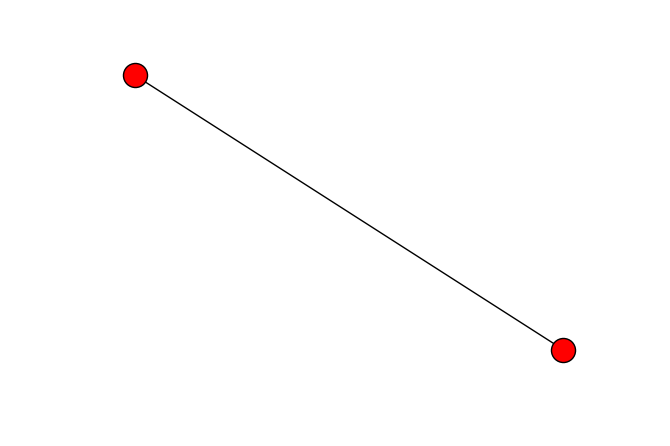

In [19]:
G=nx.Graph()     # создаём неориентированный граф
G.add_edge(1,2)  # закидываем в граф ребро с весом 1
nx.draw(G)

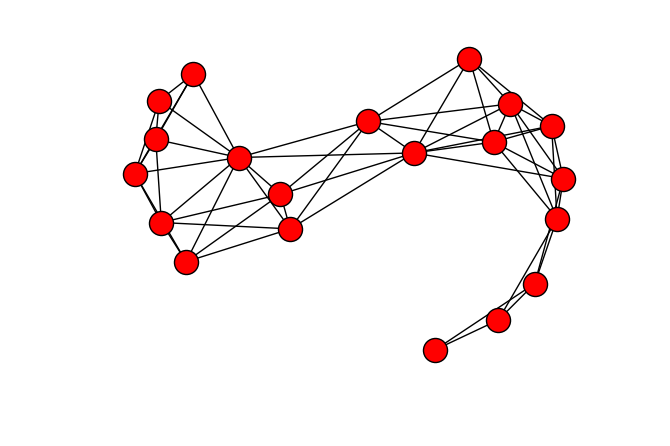

In [20]:
G = nx.random_geometric_graph(20,0.4)  # Рандомный граф из 20 вершин. Вероятность ребра 0.4
nx.draw(G) 

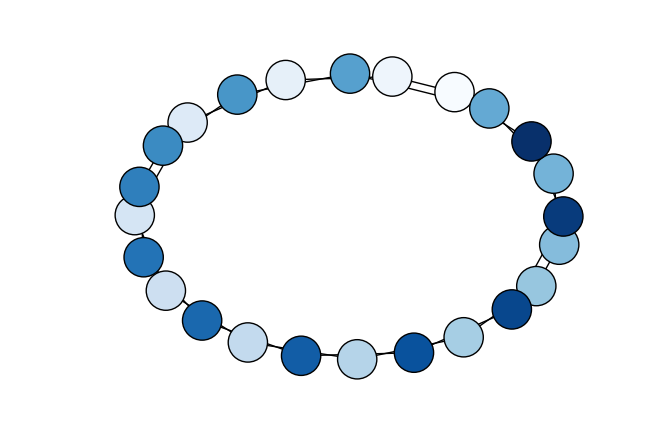

In [21]:
G=nx.cycle_graph(24)  # Нарисовать рандомный циклический граф из 24 вершин
pos=nx.spring_layout(G,iterations=200)
nx.draw(G,pos,node_color=range(24),node_size=800,cmap=plt.cm.Blues)
# plt.savefig("node_colormap.png") # можно сохранить картинку в рабочую директорию

Прошу любить и жаловать! Стрёмный граф друзей! 

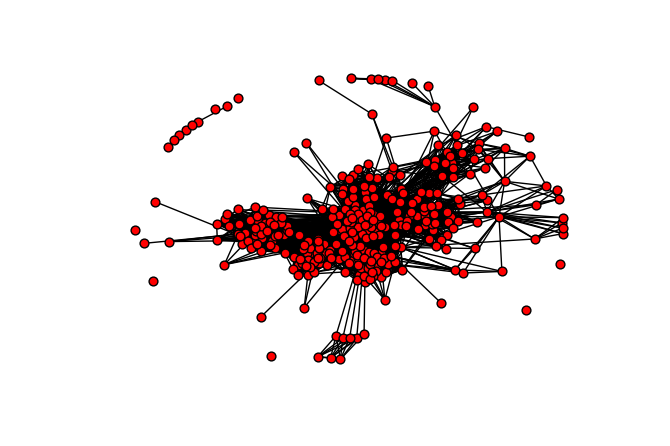

In [90]:
G = nx.from_dict_of_lists(infa)
nx.draw(G,node_size=40, cmap=True)

## 3. Украшаем наш граф

Это всё конечно круто, но хотелось бы получить более красивый граф. Хочу, чтобы в вершинах были фотки людей в кругляшках, а рядом были подписаны их имена. Слабо?! Конечно же нет. Скачаем все фотки, имена и фамилии.

In [115]:
start_time = time.time()   # Время работы кода

# Дополнительная информация, необходимая нам
we_want = 'first_name,last_name,photo_400_orig'

k = 0  # счётчки для пересчёта плохих друзей
dop_infa = { }
for friend in friends_ids:
    time.sleep(0.5)  # Спать!  
    try:
        dop = Vk_downloader('users.get','user_ids='+str(friend)+'&fields='+we_want)['response'][0]
        whoisit = dop['first_name'] + ' ' + dop['last_name']
        photo = dop['photo_400_orig']
        dop_infa[friend] = [whoisit, photo] 
    # Если юзер выпилил себя из контакта, то код выше выдаст ошибку.
    except Exception:
        dop_infa[friend] = [ ]
        k = k + 1
    
time.time() - start_time   # Время работы кода

699.409832239151

In [116]:
# Сколько неадекватов? 
print(k) 

25


In [117]:
G = nx.from_dict_of_lists(infa)
pos = nx.spring_layout(G)
pos;

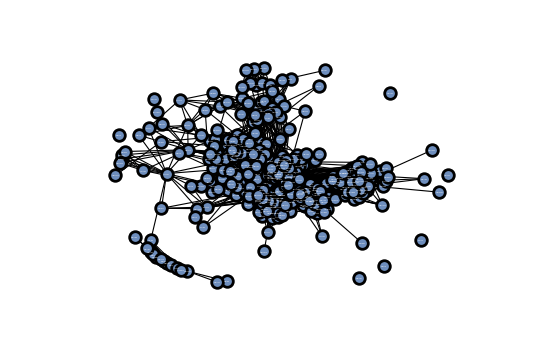

In [118]:
nx.draw_networkx_nodes(G,pos,node_color='#6E8EBD',node_size=70,linewidths=2.0);
nx.draw_networkx_labels(G,pos,font_size=0.5,font_color='w');
nx.draw_networkx_edges(G,pos,width=.8);
plt.axis('off');

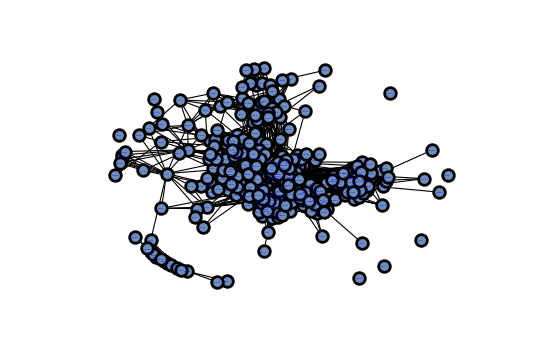

In [119]:
nx.draw_networkx_nodes(G,pos,node_color='#6E8EBD',node_size=70,linewidths=2.0);

nx.draw_networkx_labels(G,pos,font_size=0.5,font_color='b');

nx.draw_networkx_edges(G,pos,width=.8);
plt.axis('off');

In [114]:
dop_infa

{56572: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 238896: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 347530: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 530312: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 630915: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 633191: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 750115: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 1005672: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 1598589: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 1634318: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 2046984: ['The Strike',
  'https://pp.userapi.com/c636527

In [107]:
# Список вершин
nods = G.nodes( )
# Пробегаемся по каждой вершине и присваиваем ей дополнительные атрибуты, в нашем случае имя, фото и пол
for item in nods:
    G.node[item]['name'] = dop_infa[item][0]
    G.node[item]['photo'] = dop_infa[item][1]

KeyError: 86070284

In [121]:
G.node[nods[40]]

{}

In [95]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(' ')
# draw graph without images
G =nx.Graph()
G.add_edge(0,1,image=img,size=0.1)
G.add_edge(1,2,image=img,size=0.05)
G.add_edge(2,3,image=img,size=0.02)
G.add_edge(3,4,image=img,size=0.075)

pos=nx.spring_layout(G)
nx.draw(G,pos)

FileNotFoundError: [Errno 2] No such file or directory: '/home/shobhit/Desktop/shobhit.jpg'

In [96]:
dop_infa

{56572: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 238896: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 347530: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 530312: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 630915: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 633191: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 750115: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 1005672: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 1598589: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 1634318: ['The Strike',
  'https://pp.userapi.com/c636527/v636527054/645cd/ZWKF811sSI4.jpg'],
 2046984: ['The Strike',
  'https://pp.userapi.com/c636527

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/home/shobhit/Desktop/shobhit.jpg')
# draw graph without images
G =nx.Graph()
G.add_edge(0,1,image=img,size=0.1)
G.add_edge(1,2,image=img,size=0.05)
G.add_edge(2,3,image=img,size=0.02)
G.add_edge(3,4,image=img,size=0.075)

pos=nx.spring_layout(G)
nx.draw(G,pos)

# add images on edges
ax=plt.gca()
fig=plt.gcf()
label_pos = 0.5 # middle of edge, halfway between nodes
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.1 # this is the image size
for (n1,n2) in G.edges():
    (x1,y1) = pos[n1]
    (x2,y2) = pos[n2]
    (x,y) = (x1 * label_pos + x2 * (1.0 - label_pos),
             y1 * label_pos + y2 * (1.0 - label_pos))
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    imsize = G[n1][n2]['size']
    img =  G[n1][n2]['image']
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    a.imshow(img)
    a.set_aspect('equal')
    a.axis('off')
plt.savefig('/home/shobhit/Desktop/save.png') 

## 3. Красивый граф. 





Попробуем воспользоваться результатами чужого труда, а именно [статейкой с хабра](https://habrahabr.ru/post/221251/) и [репозиторием](https://github.com/stleon/vk_friends) того же автора.



Установка $d3$ на Linux: Сначала ставим некий `npm` командой `sudo apt-get install npm`. После ставим `d3` командой `sudo npm install d3`. На маке по аналогии но своими командами :) На винде как я хз. Наверное, нужно [качать архив](https://github.com/d3/d3/releases/tag/v4.8.0).




## 4. Исследование напоследок

Все ли слышали о [теории 6 рукопожатий?](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%D1%88%D0%B5%D1%81%D1%82%D0%B8_%D1%80%D1%83%D0%BA%D0%BE%D0%BF%D0%BE%D0%B6%D0%B0%D1%82%D0%B8%D0%B9) А все ли знают, что это мейнстрим? Фэйсбук давным давно [проверил всё это дело](https://arxiv.org/pdf/1111.4503.pdf) на себе любимом и сначала выдал число $4.7$, спустя некоторое время число $4.3$.  Как он это сделал? Да просто построил граф дружеских связей и посчитал его диаметр.

**Диаметром графа** называется максимальное расстояние между двумя его вершинами. 

Попробуем провернуть нечто похожее с нашим графом. Но для начала выясним является ли он связным.

Граф называется **связным**, если между любой парой его вершин существует путь.

In [ ]:
G = nx.from_dict_of_lists(infa)

In [ ]:
nx.is_connected(G)

Граф оказался несвязным. Придётся искать диаметр каждой компоненты связности по очереди. Посмотрим на компоненты.

In [ ]:
sg = nx.connected_component_subgraphs(G)
[len(s) for s in sg]

In [ ]:
sg = list(nx.connected_component_subgraphs(G))
sg

In [ ]:
nx.diameter(sg[1])

Итак, мы нашли диаметр самой большой компоненты. Его несложно проинтерпретировать. Найдём ещё парочку метрик!

**Центр графа** — это любая вершина, такая, что расстояние от нее до наиболее отдаленной вершины минимально. Центром графа может быть одна вершина или несколько вершин. Или проще. Центр графа — вершина, эксцентриситет (расстояние от этой вершины до самой удаленной от нее) которой равен радиусу. 


In [ ]:
print('Центр графа:', nx.center(sg[1]))

**Коэффициент кластеризации** — это степень вероятности того, что два разных пользователя, связанные с конкретным индивидуумом, тоже связаны.

In [ ]:
print('Коэффициент кластеризации', nx.average_clustering(sg[1]))

Ну и на последок найдём максимальную клику. **Кликой** называется такой кусок графа, что все вершины в нём связаны друг с другом. То есть это такой кусок из друзей, в котором все друзья дружат.  

Кроме уже применённых штук, можно применить ещё кучу разных алгоритмов. Подробнее про них можно посмотреть на [страничке с документацией.](https://networkx.github.io/documentation/networkx-1.9/reference/algorithms.html)